# Helpers

In [1]:
# --- Cell 1: Setup and Constants ---

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Set default plotting style
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 11})

print("✅ Environment ready: NumPy, Matplotlib, and CVXPY imported.")


✅ Environment ready: NumPy, Matplotlib, and CVXPY imported.


In [2]:
# --- Cell 2: Basic Helper Functions ---

def zero_padded(a, t):
    """
    Returns a_t with zero padding for t <= 0.
    
    Parameters
    ----------
    a : np.ndarray
        Arrival sequence of length T.
    t : int
        Time index (1-indexed).
    """
    return a[t - 1] if t > 0 else 0.0


def compute_phi(a, T, H, kappa):
    """
    Compute matrix Phi with entries:
        phi_t^(j) = kappa * sum_{i=1}^{j-1} (1-kappa)^(i-1) * a_{t-i}
                    + (1-kappa)^(j-1) * a_{t-j}
    with zero padding for a_t when t <= 0.

    Returns
    -------
    Phi : np.ndarray of shape (T, H)
    """
    Phi = np.zeros((T, H))
    for t in range(1, T + 1):
        for j in range(1, H + 1):
            term1 = kappa * sum((1 - kappa) ** (i - 1) * zero_padded(a, t - i)
                                for i in range(1, j))
            term2 = (1 - kappa) ** (j - 1) * zero_padded(a, t - j)
            Phi[t - 1, j - 1] = term1 + term2
    return Phi


def compute_psi(a, T, H, kappa):
    """
    Compute matrix Psi with entries:
        psi_t^(j) = sum_{i=1}^j (1-kappa)^(i-1) * a_{t-i}
    with zero padding for a_t when t <= 0.

    Returns
    -------
    Psi : np.ndarray of shape (T, H)
    """
    Psi = np.zeros((T, H))
    for t in range(1, T + 1):
        for j in range(1, H + 1):
            Psi[t - 1, j - 1] = sum((1 - kappa) ** (i - 1) * zero_padded(a, t - i)
                                    for i in range(1, j + 1))
    return Psi


def u_t(t, w, Phi):
    """
    Compute u_t(w) = <w, phi_t>

    Parameters
    ----------
    t : int (1-indexed)
    w : np.ndarray, shape (H,)
    Phi : np.ndarray, shape (T, H)
    """
    return np.dot(w, Phi[t - 1, :])


def b_t(t, w, Psi):
    """
    Compute b_t(w) = <w, psi_t>

    Parameters
    ----------
    t : int (1-indexed)
    w : np.ndarray, shape (H,)
    Psi : np.ndarray, shape (T, H)
    """
    return np.dot(w, Psi[t - 1, :])


def compute_sequences(w, Phi, Psi):
    """
    Compute u_t(w) and b_t(w) sequences for t=1..T.

    Returns
    -------
    u_seq : np.ndarray
        Sequence of u_t(w)
    b_seq : np.ndarray
        Sequence of b_t(w)
    """
    u_seq = np.array([u_t(t, w, Phi) for t in range(1, T + 1)])
    b_seq = np.array([b_t(t, w, Psi) for t in range(1, T + 1)])
    return u_seq, b_seq


print("✅ Basic functions loaded: zero_padded, compute_phi, compute_psi, u_t, b_t, compute_sequences")


✅ Basic functions loaded: zero_padded, compute_phi, compute_psi, u_t, b_t, compute_sequences


In [3]:
# --- Fixed Cell: Robust compare_controllers() supporting simulate_storage_dynamics ---

def compare_controllers(
    result1, name1,
    result2, name2,
    a,
    T=None,
    plot_len=None,
    color_scheme=None
):
    """
    Compare two controllers by plotting:
        (1) Backlog b_t
        (2) Usage u_t alongside arrivals a_t
        (3) Per-step costs
    Works with dicts from run_storage_optimization(), run_egpc(), or simulate_storage_dynamics().
    """

    if color_scheme is None:
        color_scheme = {
            name1: "tab:red",
            name2: "tab:blue",
            "a": "tab:gray",
        }

    # --- Safe extraction helpers ---
    def safe_get(d, *keys):
        for k in keys:
            if k in d and d[k] is not None:
                return d[k]
        return None

    # Extract sequences safely
    b1 = safe_get(result1, "b_star", "b")
    b2 = safe_get(result2, "b_star", "b")

    u1 = safe_get(result1, "u_star", "u")
    u2 = safe_get(result2, "u_star", "u")

    c1 = safe_get(result1, "c_opt", "c", "losses")
    c2 = safe_get(result2, "c_opt", "c", "losses")

    # Sanity check
    if b1 is None or b2 is None:
        raise ValueError("Missing b_t data in one of the result dictionaries.")
    if u1 is None or u2 is None:
        raise ValueError("Missing u_t data in one of the result dictionaries.")
    if c1 is None or c2 is None:
        raise ValueError("Missing cost data in one of the result dictionaries.")

    # --- Determine plotting range ---
    if T is None:
        T = min(len(b1), len(b2), len(u1), len(u2), len(a))
    if plot_len is None:
        plot_len = min(T, 1000)
    t_axis = np.arange(1, plot_len + 1)

    # --- 1. Plot b_t (battery/backlog) ---
    plt.figure(figsize=(9, 4))
    plt.plot(t_axis, b1[:plot_len], label=f"{name1} $b_t$", color=color_scheme[name1], linewidth=2.0)
    plt.plot(t_axis, b2[:plot_len], label=f"{name2} $b_t$", color=color_scheme[name2], linestyle="--", linewidth=2.0)
    plt.title(r"Battery Level $b_t$ Comparison")
    plt.xlabel("Time $t$")
    plt.ylabel(r"$b_t$")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 2. Plot u_t and arrivals a_t ---
    plt.figure(figsize=(9, 4))
    plt.plot(t_axis, a[:plot_len], label=r"$a_t$ (arrivals)", color=color_scheme["a"], linewidth=1.3)
    plt.plot(t_axis, u1[:plot_len], label=f"{name1} $u_t$", color=color_scheme[name1], linewidth=2.0)
    plt.plot(t_axis, u2[:plot_len], label=f"{name2} $u_t$", color=color_scheme[name2], linestyle="--", linewidth=2.0)
    plt.title(r"Usage Decision $u_t$ and Arrivals $a_t$")
    plt.xlabel("Time $t$")
    plt.ylabel(r"$u_t$, $a_t$")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 3. Plot per-step costs ---
    plt.figure(figsize=(9, 4))
    plt.plot(t_axis, c1[:plot_len], label=f"{name1} cost", color=color_scheme[name1], linewidth=1.8)
    plt.plot(t_axis, c2[:plot_len], label=f"{name2} cost", color=color_scheme[name2], linestyle="--", linewidth=1.8)
    plt.title(r"Per-step Cost Comparison")
    plt.xlabel("Time $t$")
    plt.ylabel(r"$c_t$")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 4. Summary ---
    print("\n──────────────────────────────")
    print(f"{name1} total cost: {np.sum(c1):.4f}")
    print(f"{name2} total cost: {np.sum(c2):.4f}")
    print(f"Difference (2 - 1): {np.sum(c2) - np.sum(c1):.4f}")
    print("──────────────────────────────")


# arrival and cost choices

## Costs

In [33]:
# --- Cell 3: Define Convex Cost Functions c_t(b, u) ---

def c_linear_neg_b(b, u, t=None):
    """c_t(b, u) = -b  (maximize throughput / minimize negative backlog)."""
    return -b


def c_linear_pos_b(b, u, t=None):
    """c_t(b, u) = +b  (minimize backlog)."""
    return b


def c_quadratic_tracking(b, u, t=None, target=1.0):
    """c_t(b, u) = b + (target - u)^2  (track u_t toward target)."""
    return b + (target - u) ** 2


def c_weighted_combo(b, u, t=None, s1=0, s2=50, target=1.0):
    """c_t(b, u) = s1*b + s2*(target - u)^2."""
    return s1 * b + s2 * (target - u) ** 2


def c_time_variant_sin(b, u, t, s1=1.0, s2=0.5, period=200):
    """c_t(b, u) = (s1 + 0.5*sin(2πt/period))*b + s2*(1 - u)^2 (periodic cost variation)."""
    weight_t = s1 + 0.5 * np.sin(2 * np.pi * t / period)
    return weight_t * b + s2 * (1 - u) ** 2


def c_time_variant_adversarial(b, u, t, s1=1.0, s2=0.5):
    """c_t(b, u) = s1*(-1)^t * b + s2*(1 - u)^2 (alternating adversarial sign)."""
    return ((-1) ** t) * s1 * b + s2 * (1 - u) ** 2


# --- NEW Burst and Unpredictable Cost Functions ---

def c_burst_fluctuating(b, u, t, s1=1.0, s2=50, burst_period=15, burst_strength=10.0):
    """
    Sudden cost spikes every few bursts.
    c_t(b,u) = s1*(1 + burst_strength*I_burst)*b + s2*(1 - u)^2
    """
    burst = int((t // burst_period) % 2 == 0)  # bursts every other period
    s1_t = s1 * (1 + burst_strength * burst)
    return s1_t * b + s2 * (1 - u) ** 2


def c_burst_randomized(b, u, t, s1=1.0, s2=0.5, seed=123):
    """
    Random bursty cost changes using pseudo-random multipliers.
    c_t(b,u) = s1*(1 + noise_t)*b + s2*(1 - u)^2
    """
    rng = np.random.default_rng(seed + t)
    noise_t = rng.uniform(-0.8, 1.2)  # random multiplier each step
    s1_t = s1 * (1 + max(-0.9, noise_t))  # cap extreme negatives
    return s1_t * b + s2 * (1 - u) ** 2


def c_burst_switching(b, u, t, s1=1.0, s2=0.5, switch_len=50, levels=(0.5, 5)):
    """
    Cost switches unpredictably between low/high regimes every 'switch_len' steps.
    c_t(b,u) = s1_t * b + s2*(1 - u)^2,  s1_t alternates between levels
    """
    phase = (t // switch_len) % 4
    s1_t = levels[0] if phase in (0, 3) else levels[1]
    return s1_t * b + s2 * (1 - u) ** 2


def c_burst_decay(b, u, t, s1=1.0, s2=5, reset_period=30):
    """
    Decaying cost that resets periodically.
    c_t(b,u) = s1*(1 + exp(-((t mod reset_period)/50)))*b + s2*(1 - u)^2
    """
    phase = t % reset_period
    s1_t = s1 * (1 + np.exp(-phase / 50))
    return s1_t * b + s2 * (1 - u) ** 2


# --- Registry of available cost functions ---
COST_FUNCTIONS = {
    "linear_-b": c_linear_neg_b,
    "linear_+b": c_linear_pos_b,
    "tracking": c_quadratic_tracking,
    "weighted": c_weighted_combo,
    "sin_time_variant": c_time_variant_sin,
    "adversarial_time_variant": c_time_variant_adversarial,
    "burst_fluctuating": c_burst_fluctuating,
    "burst_randomized": c_burst_randomized,
    "burst_switching": c_burst_switching,
    "burst_decay": c_burst_decay,
}

print("✅ Loaded cost functions:")
for name in COST_FUNCTIONS:
    print(f"  • {name}")


✅ Loaded cost functions:
  • linear_-b
  • linear_+b
  • tracking
  • weighted
  • sin_time_variant
  • adversarial_time_variant
  • burst_fluctuating
  • burst_randomized
  • burst_switching
  • burst_decay


In [5]:
# --- Cell 4: Test Convexity and DCP Compliance of Cost Functions ---

def check_convexity_cvxpy(cost_fn, name):
    """
    Check convexity and DCP compliance of a cost function using CVXPY.

    Parameters
    ----------
    cost_fn : callable
        Cost function c_t(b, u, t, **kwargs)
    name : str
        Name of the cost function (for printing)
    kwargs : dict
        Extra parameters (e.g., s1, s2, target, period)
    """
    b = cp.Variable(name="b")
    u = cp.Variable(name="u")
    t = 10  # sample time index (for time-varying costs)

    try:
        expr = cost_fn(b, u, t)
        prob = cp.Problem(cp.Minimize(expr))
        print(f"{name:30s} -> DCP compliant:", prob.is_dcp(), "| Convex:", expr.is_convex())
    except Exception as e:
        print(f"{name:30s} | ERROR: {e}")


print("🔍 Checking convexity and DCP compliance of all cost functions:\n")

# Test all registered cost functions
for key, fn in COST_FUNCTIONS.items():
    # use some typical parameter values for the check
    check_convexity_cvxpy(fn, key)


🔍 Checking convexity and DCP compliance of all cost functions:

linear_-b                      -> DCP compliant: True | Convex: True
linear_+b                      -> DCP compliant: True | Convex: True
tracking                       -> DCP compliant: True | Convex: True
weighted                       -> DCP compliant: True | Convex: True
sin_time_variant               -> DCP compliant: True | Convex: True
adversarial_time_variant       -> DCP compliant: True | Convex: True
burst_fluctuating              -> DCP compliant: True | Convex: True
burst_randomized               -> DCP compliant: True | Convex: True
burst_switching                -> DCP compliant: True | Convex: True
burst_decay                    -> DCP compliant: True | Convex: True


## Arrivals

In [6]:
# --- Cell 5: Define Arrival Sequence Generators a_t ---

def arrivals_fixed(T, amplitude=1.0, value=0.5):
    """Fixed constant arrival sequence a_t = value for all t."""
    return np.full(T, amplitude * value)


def arrivals_random(T, amplitude=1.0, seed=42):
    """i.i.d. Uniform[0,1) arrivals scaled by amplitude."""
    rng = np.random.default_rng(seed)
    return amplitude * rng.random(T)


def arrivals_gaussian(T, amplitude=1.0, mean=0.5, std=0.15, seed=42):
    """Gaussian arrivals clipped to [0,1]."""
    rng = np.random.default_rng(seed)
    a = rng.normal(mean, std, T)
    return np.clip(amplitude * a, 0.0, 1.0)


def arrivals_sinusoidal(T, amplitude=1.0, period=100, phase=0):
    """Smooth periodic sinusoidal arrivals."""
    t = np.arange(T)
    a = 0.5 * (1 + np.sin(2 * np.pi * t / period + phase))
    return amplitude * a


def arrivals_decaying(T, amplitude=1.0, decay_rate=0.002):
    """Exponentially decaying arrivals."""
    t = np.arange(T)
    return amplitude * np.exp(-decay_rate * t)


def arrivals_bursty(T, amplitude=1.0, burst_length=(20, 60), quiet_length=(40, 100), seed=123):
    """Random bursts of activity separated by quiet periods."""
    rng = np.random.default_rng(seed)
    a = np.zeros(T)
    t = 0
    while t < T:
        # burst
        blen = rng.integers(burst_length[0], burst_length[1])
        a[t:t+blen] = rng.uniform(0.7, 1.0)
        t += blen
        # quiet
        qlen = rng.integers(quiet_length[0], quiet_length[1])
        t += qlen
    return np.clip(a, 0.0, 1.0) * amplitude


def arrivals_adversarial(T, amplitude=1.0, noise_level=0.1, seed=321):
    """Alternating high/low arrivals with small noise (adversarial pattern)."""
    rng = np.random.default_rng(seed)
    a = np.array([(i % 2) for i in range(T)], dtype=float)
    a += noise_level * rng.standard_normal(T)
    return np.clip(amplitude * a, 0.0, 1.0)


def arrivals_switching_regime(T, amplitude=1.0, switch_period=200, seed=999):
    """Switches between low/high mean regimes."""
    rng = np.random.default_rng(seed)
    a = np.zeros(T)
    for t in range(T):
        regime = (t // switch_period) % 2
        mean = 0.2 if regime == 0 else 0.8
        a[t] = np.clip(rng.normal(mean, 0.1), 0, 1)
    return amplitude * a


def arrivals_spike_decay(T, amplitude=1.0, spike_every=150, decay_len=50):
    """Occasional spikes followed by exponential decay."""
    a = np.zeros(T)
    for spike_start in range(0, T, spike_every):
        for k in range(decay_len):
            if spike_start + k < T:
                a[spike_start + k] = amplitude * np.exp(-0.1 * k)
    return np.clip(a, 0.0, 1.0)


def arrivals_piecewise_linear(T, amplitude=1.0, segments=5, seed=456):
    """Piecewise linear random segments (smooth but nonstationary)."""
    rng = np.random.default_rng(seed)
    breakpoints = np.linspace(0, T, segments + 1, dtype=int)
    a = np.zeros(T)
    for i in range(segments):
        start, end = breakpoints[i], breakpoints[i + 1]
        start_val = rng.uniform(0, 1)
        end_val = rng.uniform(0, 1)
        a[start:end] = np.linspace(start_val, end_val, end - start)
    return amplitude * np.clip(a, 0.0, 1.0)


# --- Registry of available arrivals ---
ARRIVAL_FUNCTIONS = {
    "fixed": arrivals_fixed,
    "random": arrivals_random,
    "gaussian": arrivals_gaussian,
    "sinusoidal": arrivals_sinusoidal,
    "decaying": arrivals_decaying,
    "bursty": arrivals_bursty,
    "adversarial": arrivals_adversarial,
    "switching": arrivals_switching_regime,
    "spike_decay": arrivals_spike_decay,
    "piecewise_linear": arrivals_piecewise_linear,
}

print("✅ Loaded arrival sequence generators:")
for name in ARRIVAL_FUNCTIONS:
    print(f"  • {name}")


✅ Loaded arrival sequence generators:
  • fixed
  • random
  • gaussian
  • sinusoidal
  • decaying
  • bursty
  • adversarial
  • switching
  • spike_decay
  • piecewise_linear


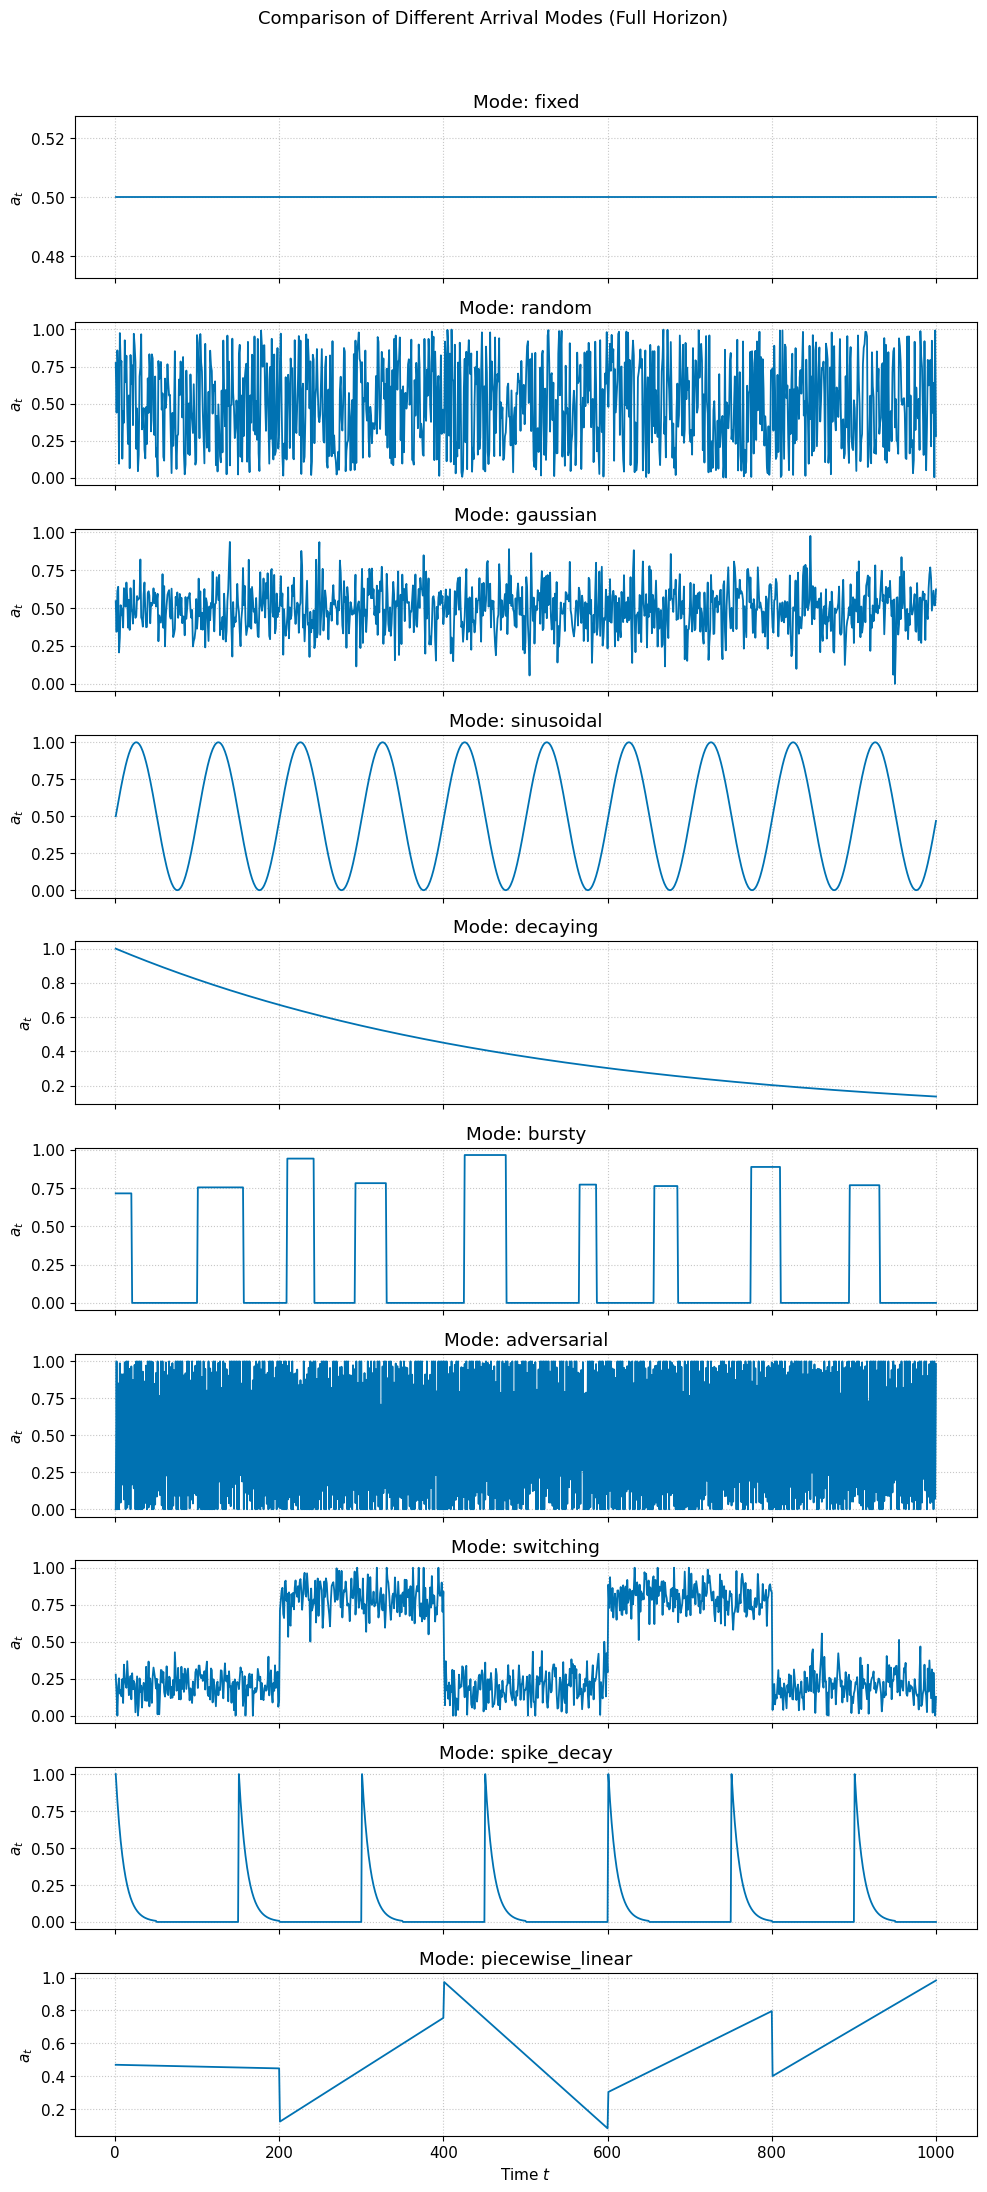

In [7]:
# --- Cell 6: Visualize All Arrival Types (Full T) ---

def plot_all_arrival_modes(T=1000):
    """
    Plot all available arrival sequence generators over the full time horizon T.
    Each row corresponds to one mode in ARRIVAL_FUNCTIONS.
    """
    t_axis = np.arange(1, T + 1)
    n_modes = len(ARRIVAL_FUNCTIONS)

    fig, axes = plt.subplots(n_modes, 1, figsize=(10, 2.2 * n_modes), sharex=True)

    if n_modes == 1:
        axes = [axes]  # ensure iterable if single plot

    for ax, (mode_name, fn) in zip(axes, ARRIVAL_FUNCTIONS.items()):
        a = fn(T)  # use default amplitude inside each generator
        ax.plot(t_axis, a, linewidth=1.3)
        ax.set_ylabel(r"$a_t$")
        ax.set_title(f"Mode: {mode_name}")
        ax.grid(True, linestyle=":", alpha=0.7)

    axes[-1].set_xlabel("Time $t$")
    plt.suptitle("Comparison of Different Arrival Modes (Full Horizon)", y=0.995, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


# --- Example usage ---
plot_all_arrival_modes(T=1000)


# W^* finding

## Main solver

In [8]:
'''# --- Final Cell 7 (Cleaned): Offline Optimal Controller (no plots) ---

def run_storage_optimization(
    a_mode="random",
    cost_key="weighted",
    cost_kwargs=None,
    a_kwargs=None,
    T=1000,
    H=20,
    kappa=0.1,
    amplitude=1.0,
    verbose=False
):
    """
    End-to-end offline optimization:
        1. Generate a_t via ARRIVAL_FUNCTIONS
        2. Compute Φ, Ψ matrices
        3. Solve min_w ∑_t c_t(b_t(w), u_t(w)) over simplex
        4. Return all data (no plotting)
    """
    import warnings
    if not verbose:
        warnings.filterwarnings("ignore", message="Objective contains too many subexpressions")

    if cost_kwargs is None:
        cost_kwargs = {}
    if a_kwargs is None:
        a_kwargs = {}

    # --- 1. Generate arrivals ---
    if a_mode not in ARRIVAL_FUNCTIONS:
        raise ValueError(f"Unknown a_mode '{a_mode}'. Available: {list(ARRIVAL_FUNCTIONS.keys())}")
    a_fn = ARRIVAL_FUNCTIONS[a_mode]
    try:
        a = a_fn(T, amplitude=amplitude, **a_kwargs)
    except TypeError:
        a = a_fn(T, **a_kwargs)

    # --- 2. Compute Φ and Ψ ---
    Phi = compute_phi(a, T, H, kappa)
    Psi = compute_psi(a, T, H, kappa)

    # --- 3. Solve convex program ---
    if cost_key not in COST_FUNCTIONS:
        raise ValueError(f"Unknown cost_key '{cost_key}'. Available: {list(COST_FUNCTIONS.keys())}")
    cost_fn = COST_FUNCTIONS[cost_key]

    w = cp.Variable(H, nonneg=True)
    constraints = [cp.sum(w) == 1]
    terms = [cost_fn(Psi[t, :] @ w, Phi[t, :] @ w, t + 1, **cost_kwargs) for t in range(T)]
    total_cost = cp.sum(cp.hstack(terms))
    prob = cp.Problem(cp.Minimize(total_cost), constraints)
    prob.solve(verbose=verbose)

    # --- 4. Extract results ---
    w_star = np.array(w.value).flatten()
    b_star = Psi @ w_star
    u_star = Phi @ w_star
    c_opt = np.array([cost_fn(b_star[t], u_star[t], t + 1, **cost_kwargs) for t in range(T)])

    # --- Summary print ---
    print("\n──────────────────────────────")
    print(f"Offline Optimization Complete")
    print(f"Arrival mode:   {a_mode}")
    print(f"Cost function:  {cost_key}")
    print(f"Total cost (opt): {np.sum(c_opt):.4f}")
    print("Optimal w* (rounded):", np.round(w_star, 4))
    print(f"Sum(w*): {np.sum(w_star):.4f}")
    print("──────────────────────────────")

    return {
        "a": a,
        "Phi": Phi,
        "Psi": Psi,
        "w_star": w_star,
        "b_star": b_star,
        "u_star": u_star,
        "c_opt": c_opt,
        "objective": prob.value,
    }
'''

'# --- Final Cell 7 (Cleaned): Offline Optimal Controller (no plots) ---\n\ndef run_storage_optimization(\n    a_mode="random",\n    cost_key="weighted",\n    cost_kwargs=None,\n    a_kwargs=None,\n    T=1000,\n    H=20,\n    kappa=0.1,\n    amplitude=1.0,\n    verbose=False\n):\n    """\n    End-to-end offline optimization:\n        1. Generate a_t via ARRIVAL_FUNCTIONS\n        2. Compute Φ, Ψ matrices\n        3. Solve min_w ∑_t c_t(b_t(w), u_t(w)) over simplex\n        4. Return all data (no plotting)\n    """\n    import warnings\n    if not verbose:\n        warnings.filterwarnings("ignore", message="Objective contains too many subexpressions")\n\n    if cost_kwargs is None:\n        cost_kwargs = {}\n    if a_kwargs is None:\n        a_kwargs = {}\n\n    # --- 1. Generate arrivals ---\n    if a_mode not in ARRIVAL_FUNCTIONS:\n        raise ValueError(f"Unknown a_mode \'{a_mode}\'. Available: {list(ARRIVAL_FUNCTIONS.keys())}")\n    a_fn = ARRIVAL_FUNCTIONS[a_mode]\n    try:\n    

In [9]:
# --- Cell: Offline Optimization Split into Solve + Simulate ---

def solve_optimal_w(
    a_mode="random",
    cost_key="weighted",
    cost_kwargs=None,
    a_kwargs=None,
    T=1000,
    H=20,
    kappa=0.1,
    amplitude=1.0,
    verbose=False
):
    """
    Solve for the optimal w* minimizing ∑_t c_t(b_t(w), u_t(w)).

    Returns:
        dict with keys: {a, Phi, Psi, w_star, objective}
    """
    import warnings
    if not verbose:
        warnings.filterwarnings("ignore", message="Objective contains too many subexpressions")

    if cost_kwargs is None:
        cost_kwargs = {}
    if a_kwargs is None:
        a_kwargs = {}

    # --- Generate arrivals ---
    if a_mode not in ARRIVAL_FUNCTIONS:
        raise ValueError(f"Unknown a_mode '{a_mode}'. Available: {list(ARRIVAL_FUNCTIONS.keys())}")
    a_fn = ARRIVAL_FUNCTIONS[a_mode]
    try:
        a = a_fn(T, amplitude=amplitude, **a_kwargs)
    except TypeError:
        a = a_fn(T, **a_kwargs)

    # --- Compute Φ and Ψ ---
    Phi = compute_phi(a, T, H, kappa)
    Psi = compute_psi(a, T, H, kappa)

    # --- Solve for optimal w ---
    if cost_key not in COST_FUNCTIONS:
        raise ValueError(f"Unknown cost_key '{cost_key}'. Available: {list(COST_FUNCTIONS.keys())}")
    cost_fn = COST_FUNCTIONS[cost_key]

    w = cp.Variable(H, nonneg=True)
    constraints = [cp.sum(w) == 1]
    terms = [cost_fn(Psi[t, :] @ w, Phi[t, :] @ w, t + 1, **cost_kwargs) for t in range(T)]
    total_cost = cp.sum(cp.hstack(terms))
    prob = cp.Problem(cp.Minimize(total_cost), constraints)
    prob.solve(verbose=verbose)

    w_star = np.array(w.value).flatten()

    print("\n──────────────────────────────")
    print(f"Optimal weight vector found for '{a_mode}' | cost='{cost_key}'")
    print(f"Total objective: {prob.value:.4f}")
    print("w* (rounded):", np.round(w_star, 4))
    print(f"Sum(w*): {np.sum(w_star):.4f}")
    print("──────────────────────────────")

    return {
        "a": a,
        "Phi": Phi,
        "Psi": Psi,
        "w_star": w_star,
        "objective": prob.value,
    }




In [10]:
def simulate_storage_dynamics(
    Phi,
    Psi,
    a,
    w,
    cost_key="weighted",
    cost_kwargs=None
):
    """
    Simulate b_t, u_t, and c_t for a given fixed weight vector w.

    Returns:
        dict with keys: {b, u, c, total_cost}
    """
    if cost_kwargs is None:
        cost_kwargs = {}

    if cost_key not in COST_FUNCTIONS:
        raise ValueError(f"Unknown cost_key '{cost_key}'.")
    cost_fn = COST_FUNCTIONS[cost_key]

    T = len(a)
    b = Psi @ w
    u = Phi @ w
    c = np.array([cost_fn(b[t], u[t], t + 1, **cost_kwargs) for t in range(T)])

    return {"b": b, "u": u, "c": c, "total_cost": np.sum(c)}

## example


──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Total objective: 14085.9853
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


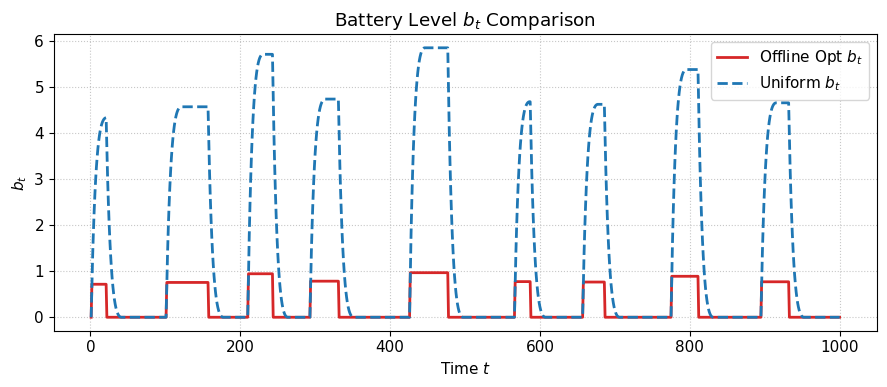

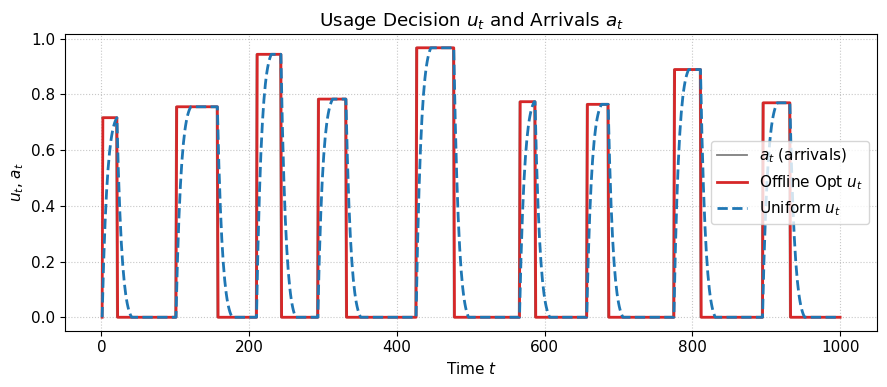

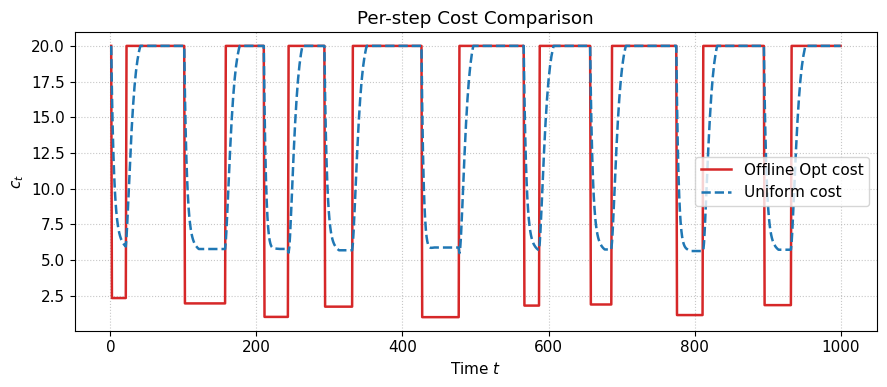


──────────────────────────────
Offline Opt total cost: 14085.9853
Uniform total cost: 14818.0860
Difference (2 - 1): 732.1007
──────────────────────────────


In [11]:
# --- Example: Solve for w*, then simulate different controllers ---
cost_key = "weighted"
# Step 1: Find the optimal w*
opt_data = solve_optimal_w(
    a_mode="bursty",
    cost_key=cost_key,
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 2: Simulate w* (optimal) and uniform weights
opt_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                    opt_data["w_star"], cost_key=cost_key,)

unif_w = np.ones_like(opt_data["w_star"]) / len(opt_data["w_star"])
unif_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                     unif_w, cost_key=cost_key,)

# Step 3: Visualize the comparison
compare_controllers(opt_sim, "Offline Opt", unif_sim, "Uniform", a=opt_data["a"])



──────────────────────────────
Optimal weight vector found for 'bursty' | cost='adversarial_time_variant'
Total objective: 322.8981
w* (rounded): [0.0822 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.9178]
Sum(w*): 1.0000
──────────────────────────────


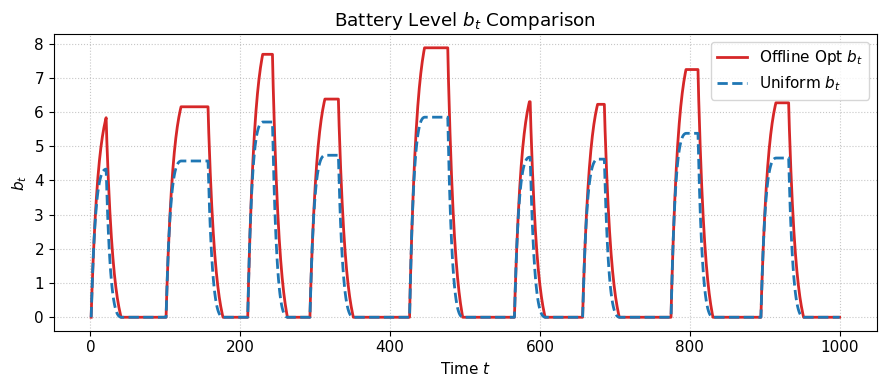

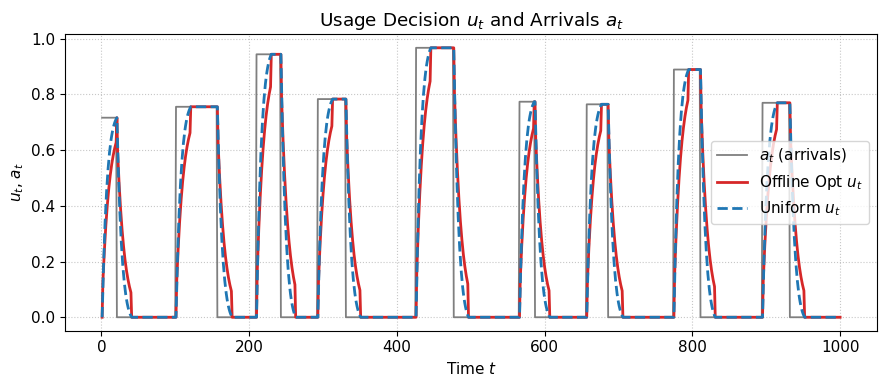

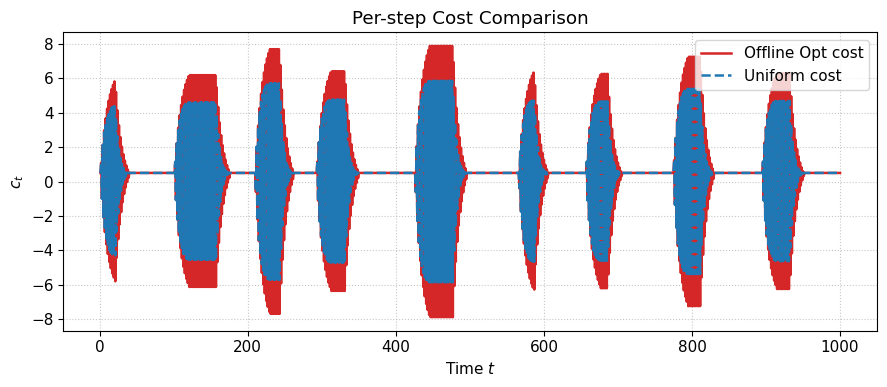


──────────────────────────────
Offline Opt total cost: 322.8981
Uniform total cost: 329.6649
Difference (2 - 1): 6.7668
──────────────────────────────


In [22]:
# --- Example: Solve for w*, then simulate different controllers ---
cost_key="adversarial_time_variant"
# Step 1: Find the optimal w*
opt_data = solve_optimal_w(
    a_mode="bursty",
     cost_key=cost_key,
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 2: Simulate w* (optimal) and uniform weights
opt_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                    opt_data["w_star"], cost_key=cost_key,)

unif_w = np.ones_like(opt_data["w_star"]) / len(opt_data["w_star"])
unif_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                     unif_w, cost_key=cost_key,)

# Step 3: Visualize the comparison
compare_controllers(opt_sim, "Offline Opt", unif_sim, "Uniform", a=opt_data["a"])



──────────────────────────────
Optimal weight vector found for 'random' | cost='weighted'
Total objective: 13138.1378
w* (rounded): [0.     0.     0.     0.     0.002  0.0125 0.0257 0.0275 0.0401 0.0275
 0.0252 0.0412 0.062  0.0705 0.077  0.0881 0.0972 0.1255 0.147  0.131 ]
Sum(w*): 1.0000
──────────────────────────────


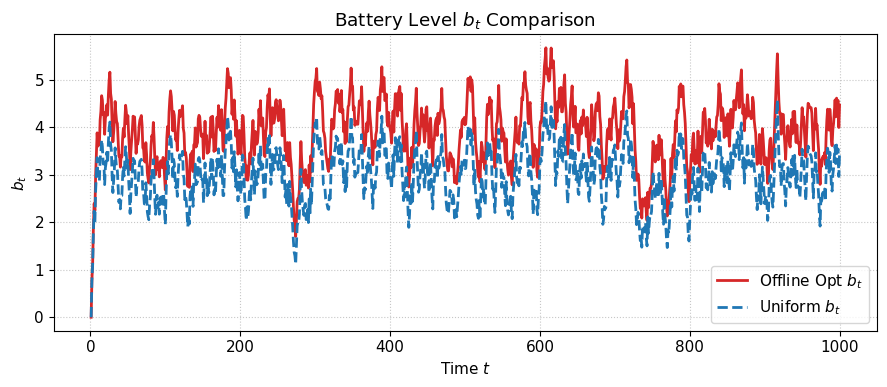

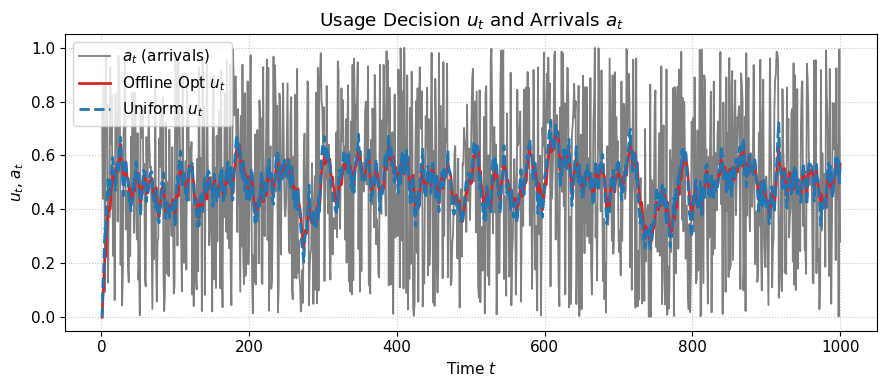

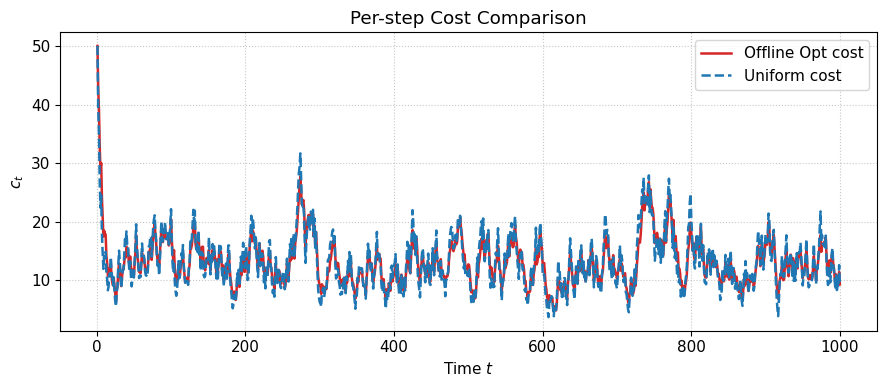


──────────────────────────────
Offline Opt total cost: 13138.1378
Uniform total cost: 13176.7949
Difference (2 - 1): 38.6571
──────────────────────────────


In [34]:
# --- Example: Solve for w*, then simulate different controllers ---
cost_key="weighted"
# Step 1: Find the optimal w*
opt_data = solve_optimal_w(
    a_mode="random",
     cost_key=cost_key,
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 2: Simulate w* (optimal) and uniform weights
opt_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                    opt_data["w_star"], cost_key=cost_key,)

unif_w = np.ones_like(opt_data["w_star"]) / len(opt_data["w_star"])
unif_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                     unif_w, cost_key=cost_key,)

# Step 3: Visualize the comparison
compare_controllers(opt_sim, "Offline Opt", unif_sim, "Uniform", a=opt_data["a"])



──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Total objective: 14085.9853
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────


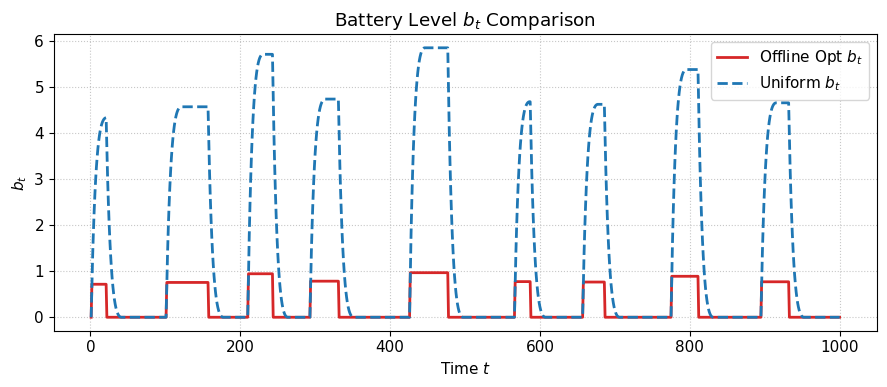

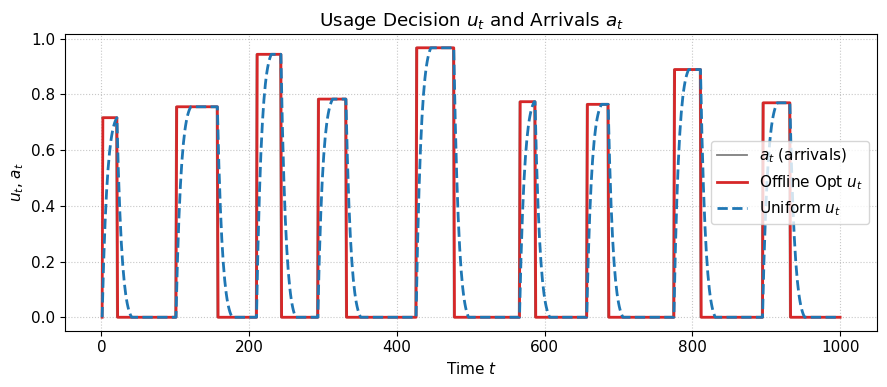

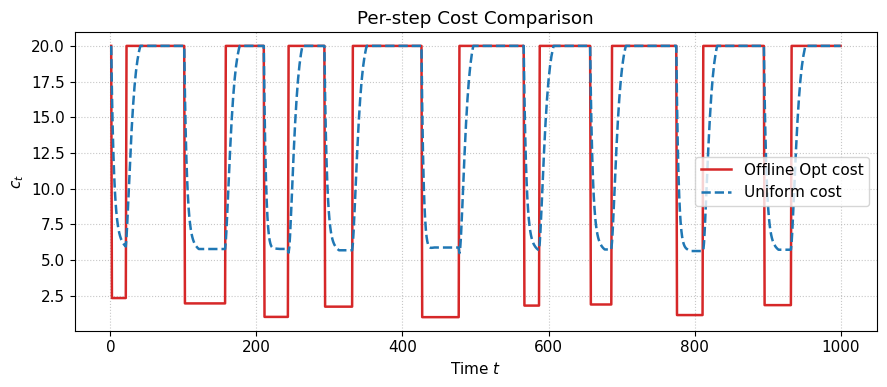


──────────────────────────────
Offline Opt total cost: 14085.9853
Uniform total cost: 14818.0860
Difference (2 - 1): 732.1007
──────────────────────────────


In [29]:
# --- Example: Solve for w*, then simulate different controllers ---
cost_key="weighted"
# Step 1: Find the optimal w*
opt_data = solve_optimal_w(
    a_mode="bursty",
     cost_key=cost_key,
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 2: Simulate w* (optimal) and uniform weights
opt_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                    opt_data["w_star"], cost_key=cost_key,)

unif_w = np.ones_like(opt_data["w_star"]) / len(opt_data["w_star"])
unif_sim = simulate_storage_dynamics(opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                                     unif_w, cost_key=cost_key,)

# Step 3: Visualize the comparison
compare_controllers(opt_sim, "Offline Opt", unif_sim, "Uniform", a=opt_data["a"])


## A long loop over all combos of a and c

will save the interesting $w^*$ in a txt file

In [13]:
# --- Cell 8: Batch Experiment Loop — Save Only Interesting (Non-Degenerate) w* ---

def run_all_combinations(
    T=1000, H=20, kappa=0.1,
    verbose=False,
    save_path="interesting_combinations.txt",
    tol=1e-6
):
    """
    Runs solve_optimal_w() for all (arrival, cost) combinations
    and records only those with non-degenerate w* (not all weight on one coordinate).
    
    Saves a compact summary text file listing interesting (a_mode, cost_key) pairs.
    """
    interesting_combos = []
    total_runs = len(ARRIVAL_FUNCTIONS) * len(COST_FUNCTIONS)

    print(f"🚀 Running {total_runs} experiments "
          f"(|arrivals|={len(ARRIVAL_FUNCTIONS)}, |costs|={len(COST_FUNCTIONS)})\n")

    for i, (a_mode, cost_key) in enumerate(
        [(a, c) for a in ARRIVAL_FUNCTIONS.keys() for c in COST_FUNCTIONS.keys()],
        start=1
    ):
        print(f"─── ({i}/{total_runs}) a_mode='{a_mode}' | cost='{cost_key}' ───")

        try:
            # Step 1: Solve offline optimization for this pair
            result = solve_optimal_w(
                a_mode=a_mode,
                cost_key=cost_key,
                T=T, H=H, kappa=kappa,
                verbose=verbose
            )

            w_star = np.array(result["w_star"]).flatten()

            # Step 2: Check for degeneracy (single coordinate weight)
            max_idx = np.argmax(w_star)
            one_hot_vec = np.zeros_like(w_star)
            one_hot_vec[max_idx] = 1.0
            is_onehot = np.allclose(w_star, one_hot_vec, atol=tol)

            if not is_onehot:
                interesting_combos.append((a_mode, cost_key))
                print(f"✅ Non-degenerate w*: saved ({a_mode}, {cost_key})")
            else:
                print(f"⚪ Degenerate w*: skipped ({a_mode}, {cost_key})")

        except Exception as e:
            print(f"❌ Error on ({a_mode}, {cost_key}): {e}\n")

    # --- Step 3: Save results ---
    if interesting_combos:
        with open(save_path, "w") as f:
            f.write("# Non-degenerate combinations (w* not one-hot)\n")
            for (a_mode, cost_key) in interesting_combos:
                f.write(f"{a_mode},{cost_key}\n")
        print(f"\n💾 Saved {len(interesting_combos)} interesting combos → {save_path}")
    else:
        print("\n⚠️ No non-degenerate w* combinations found.")

    print("🏁 Finished all combinations.\n")
    return interesting_combos


In [14]:
# --- Example ---
interesting_combos = run_all_combinations(T=1000, H=20, kappa=0.1, verbose=False)

print("\nInteresting non-degenerate combinations:")
for a_mode, cost_key in interesting_combos:
    print(f"  → {a_mode:15s} | {cost_key}")


🚀 Running 100 experiments (|arrivals|=10, |costs|=10)

─── (1/100) a_mode='fixed' | cost='linear_-b' ───

──────────────────────────────
Optimal weight vector found for 'fixed' | cost='linear_-b'
Total objective: -4360.3532
w* (rounded): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Sum(w*): 1.0000
──────────────────────────────
⚪ Degenerate w*: skipped (fixed, linear_-b)
─── (2/100) a_mode='fixed' | cost='linear_+b' ───

──────────────────────────────
Optimal weight vector found for 'fixed' | cost='linear_+b'
Total objective: 499.5000
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────
⚪ Degenerate w*: skipped (fixed, linear_+b)
─── (3/100) a_mode='fixed' | cost='tracking' ───

──────────────────────────────
Optimal weight vector found for 'fixed' | cost='tracking'
Total objective: 750.2500
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────

## Read and run the interseting combos

In [15]:
# --- Cell 9: Re-run only interesting combinations from text file (modular pipeline) ---

def run_from_saved_combos(
    file_path="interesting_combinations.txt",
    T=1000, H=20, kappa=0.1,
    verbose=False
):
    """
    Read saved (a_mode, cost_key) pairs from a text file and
    re-run solve_optimal_w() + simulate_storage_dynamics()
    for those combinations only.

    Returns:
        results : dict mapping (a_mode, cost_key) → {
            "w_star", "a", "Phi", "Psi", "b", "u", "c", "total_cost"
        }
    """
    combos = []
    # --- 1. Load combinations from text file ---
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split(",")
            if len(parts) == 2:
                a_mode, cost_key = parts
                combos.append((a_mode.strip(), cost_key.strip()))

    if not combos:
        print(f"⚠️ No valid combinations found in {file_path}.")
        return {}

    print(f"📂 Loaded {len(combos)} combinations from {file_path}.\n")

    results = {}
    # --- 2. Loop over saved pairs ---
    for i, (a_mode, cost_key) in enumerate(combos, start=1):
        print(f"─── ({i}/{len(combos)}) a_mode='{a_mode}' | cost='{cost_key}' ───")

        try:
            # Step 1: Solve for w*
            opt_data = solve_optimal_w(
                a_mode=a_mode,
                cost_key=cost_key,
                T=T, H=H, kappa=kappa,
                verbose=verbose
            )

            # Step 2: Simulate the obtained w*
            sim_data = simulate_storage_dynamics(
                opt_data["Phi"], opt_data["Psi"], opt_data["a"],
                opt_data["w_star"],
                cost_key=cost_key
            )

            results[(a_mode, cost_key)] = {
                "a": opt_data["a"],
                "Phi": opt_data["Phi"],
                "Psi": opt_data["Psi"],
                "w_star": opt_data["w_star"],
                "b": sim_data["b"],
                "u": sim_data["u"],
                "c": sim_data["c"],
                "total_cost": sim_data["total_cost"],
                "objective": opt_data["objective"],
            }

            print(f"✅ Done ({a_mode}, {cost_key}) | total_cost={sim_data['total_cost']:.3f}")

        except Exception as e:
            print(f"❌ Error for ({a_mode}, {cost_key}): {e}\n")

    print("\n🏁 Finished re-running saved combinations.\n")
    return results


In [16]:
# --- Example: Load and re-run only interesting combinations ---
results_subset = run_from_saved_combos(
    file_path="interesting_combinations.txt",
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Inspect one result (e.g., first combo)
first_key = next(iter(results_subset))
r = results_subset[first_key]
print(f"\nExample combo: {first_key}")
print(f"Total cost: {r['total_cost']:.3f},  Objective: {r['objective']:.3f}")
print(f"w*: {np.round(r['w_star'], 4)}")


📂 Loaded 15 combinations from interesting_combinations.txt.

─── (1/15) a_mode='random' | cost='weighted' ───

──────────────────────────────
Optimal weight vector found for 'random' | cost='weighted'
Total objective: 6580.4464
w* (rounded): [0.4194 0.3366 0.2016 0.0423 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Sum(w*): 1.0000
──────────────────────────────
✅ Done (random, weighted) | total_cost=6580.446
─── (2/15) a_mode='random' | cost='adversarial_time_variant' ───

──────────────────────────────
Optimal weight vector found for 'random' | cost='adversarial_time_variant'
Total objective: 127.1718
w* (rounded): [0.0685 0.     0.0846 0.     0.104  0.     0.1495 0.     0.1678 0.
 0.1288 0.     0.1623 0.     0.1107 0.     0.0239 0.     0.     0.    ]
Sum(w*): 1.0000
──────────────────────────────
✅ Done (random, adversarial_time_variant) | total_cost=127.172
─── (3/15) a_mode='random' | cost='burst_fluctuating' ───

────

# Online Algorithm

In [17]:
# --- Cell X: Exponentiated-Gradient Perturbation Controller (EGPC) ---

def run_egpc(
    a_mode="random",
    cost_key="weighted",
    eta=0.05,
    T=1000,
    H=20,
    kappa=0.1,
    a_kwargs=None,
    cost_kwargs=None,
    verbose=False,
):
    """
    Exponentiated-Gradient Perturbation Controller (EGPC)

    Implements Algorithm 2 described in LaTeX form:
        For t = 0,...,T:
          - observe arrival a_t
          - compute feasible usage u_t^A = min( κ b_t^A + <w_t, a_vec_t>, b_t^A )
          - update backlog b_{t+1} = b_t + a_t - u_t^A
          - compute surrogate loss c_t(b_t(w), u_t(w))
          - update weights w_{t+1} via exponentiated gradient
    """
    import warnings
    if not verbose:
        warnings.filterwarnings("ignore", message="Objective contains too many subexpressions")

    if a_kwargs is None:
        a_kwargs = {}
    if cost_kwargs is None:
        cost_kwargs = {}

    # --- 1. Generate arrival sequence ---
    if a_mode not in ARRIVAL_FUNCTIONS:
        raise ValueError(f"Unknown a_mode '{a_mode}'")
    a_fn = ARRIVAL_FUNCTIONS[a_mode]
    try:
        a = a_fn(T, **a_kwargs)
    except TypeError:
        a = a_fn(T)

    # Initialize state and weight
    b = np.zeros(T + 1)
    w = np.ones(H) / H
    W = np.zeros((T + 1, H))
    W[0, :] = w

    # Track decisions and costs
    u = np.zeros(T)
    losses = np.zeros(T)

    # --- 2. Get cost function ---
    if cost_key not in COST_FUNCTIONS:
        raise ValueError(f"Unknown cost_key '{cost_key}'")
    cost_fn = COST_FUNCTIONS[cost_key]

    # --- 3. Main EGPC loop ---
    for t in range(T):
        # Construct a_t vector for perturbation memory
        a_vec = np.array([(1 - kappa) ** (j + 1) * (a[t - (j + 1)] if t - (j + 1) >= 0 else 0.0)
                          for j in range(H)])

        # Tentative and feasible usage
        u_hat = kappa * b[t] + np.dot(w, a_vec)
        u[t] = min(u_hat, b[t])

        # Observe new arrival a_t (already given), update state
        b[t + 1] = b[t] + a[t] - u[t]

        # Compute surrogate features φ_t, ψ_t for gradient
        Phi_t = np.array([
            kappa * sum((1 - kappa) ** (i - 1) * (a[t - i] if t - i >= 0 else 0.0)
                        for i in range(1, j))
            + (1 - kappa) ** (j - 1) * (a[t - j] if t - j >= 0 else 0.0)
            for j in range(1, H + 1)
        ])
        Psi_t = np.array([
            sum((1 - kappa) ** (i - 1) * (a[t - i] if t - i >= 0 else 0.0)
                for i in range(1, j + 1))
            for j in range(1, H + 1)
        ])

        # Compute surrogate loss and gradient
        b_t_w = np.dot(w, Psi_t)
        u_t_w = np.dot(w, Phi_t)
        loss_val = cost_fn(b_t_w, u_t_w, t + 1, **cost_kwargs)
        losses[t] = loss_val

        # Finite difference gradient approximation
        grad = np.zeros_like(w)
        eps = 1e-6
        for i in range(H):
            w_perturb = w.copy()
            w_perturb[i] += eps
            w_perturb /= np.sum(w_perturb)
            b_pert = np.dot(w_perturb, Psi_t)
            u_pert = np.dot(w_perturb, Phi_t)
            grad[i] = (cost_fn(b_pert, u_pert, t + 1, **cost_kwargs) - loss_val) / eps

        # Exponentiated-gradient update
        w_hat = w * np.exp(-eta * grad)
        w = w_hat / np.sum(w_hat)
        W[t + 1, :] = w

    # --- 4. Output summary ---
    print("\n──────────────────────────────")
    print(f"Algorithm: EGPC")
    print(f"Arrival mode:   {a_mode}")
    print(f"Cost function:  {cost_key}")
    print(f"η = {eta}, κ = {kappa}, H = {H}, T = {T}")
    print(f"Final w_T (rounded): {np.round(w, 4)}")
    print(f"Sum(w_T): {np.sum(w):.4f}")
    print("──────────────────────────────")

    # --- 5. Return all results ---
    return {
        "a": a,
        "b": b,
        "u": u,
        "losses": losses,
        "W": W,
        "final_w": w,
    }





In [18]:
# --- Example usage ---
result_egpc = run_egpc(
    a_mode="bursty",
    cost_key="weighted",
    eta=0.05,
    T=1000,
    H=20,
    kappa=0.1,
    verbose=False
 )


──────────────────────────────
Algorithm: EGPC
Arrival mode:   bursty
Cost function:  weighted
η = 0.05, κ = 0.1, H = 20, T = 1000
Final w_T (rounded): [9.656e-01 2.970e-02 3.500e-03 8.000e-04 2.000e-04 1.000e-04 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Sum(w_T): 1.0000
──────────────────────────────


## Online algorithm V.S. the optimal $w^*$


──────────────────────────────
Optimal weight vector found for 'bursty' | cost='weighted'
Total objective: 14085.9853
w* (rounded): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum(w*): 1.0000
──────────────────────────────

──────────────────────────────
Algorithm: EGPC
Arrival mode:   bursty
Cost function:  weighted
η = 0.05, κ = 0.1, H = 20, T = 1000
Final w_T (rounded): [9.656e-01 2.970e-02 3.500e-03 8.000e-04 2.000e-04 1.000e-04 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Sum(w_T): 1.0000
──────────────────────────────


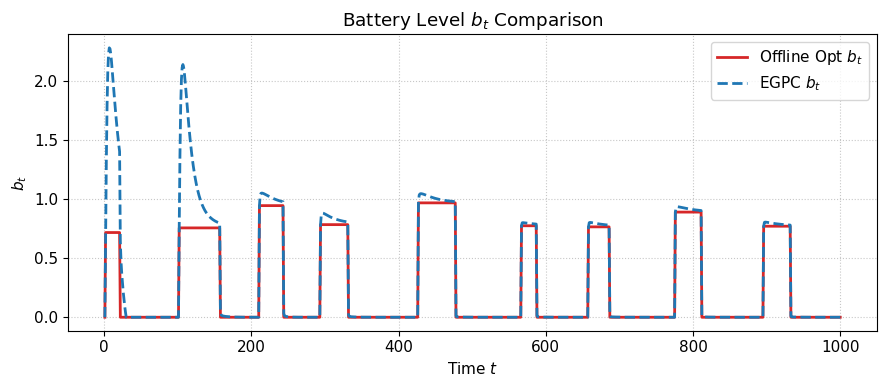

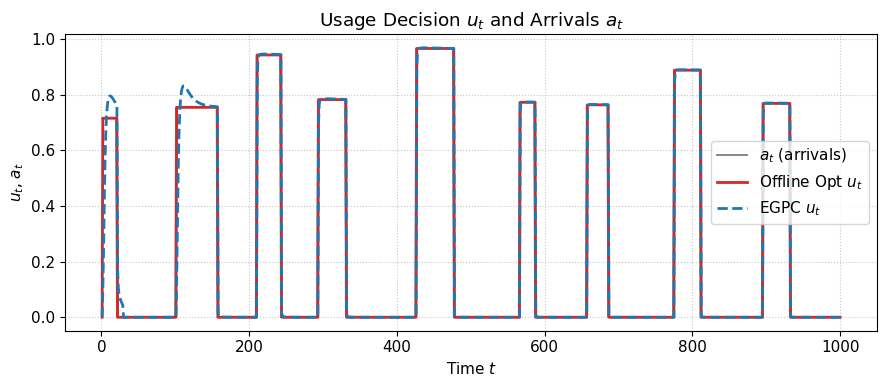

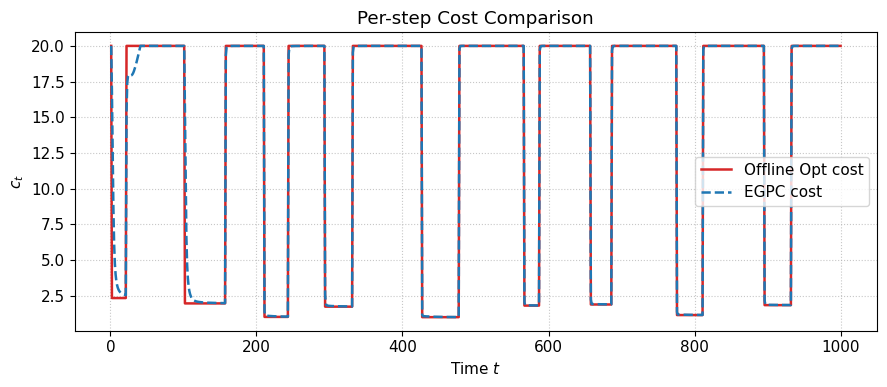


──────────────────────────────
Offline Opt total cost: 14085.9853
EGPC total cost: 14141.1552
Difference (2 - 1): 55.1698
──────────────────────────────


In [19]:
# --- Cell X: Compare Offline Optimal Controller vs EGPC ---

# Step 1️⃣: Solve for w* using the offline optimization
opt_data = solve_optimal_w(
    a_mode="bursty",
    cost_key="weighted",
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 2️⃣: Simulate the offline optimal controller
opt_sim = simulate_storage_dynamics(
    opt_data["Phi"],
    opt_data["Psi"],
    opt_data["a"],
    opt_data["w_star"],
    cost_key="weighted"
)

# Step 3️⃣: Run the online Exponentiated Gradient Perturbation Controller (EGPC)
egpc_result = run_egpc(
    a_mode="bursty",
    cost_key="weighted",
    eta=0.05,
    T=1000, H=20, kappa=0.1,
    verbose=False
)

# Step 4️⃣: Compare both controllers visually
compare_controllers(
    opt_sim, "Offline Opt",
    egpc_result, "EGPC",
    a=opt_data["a"]
)
